In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [3]:
df=pd.read_csv("/content/Solana Historical Data.csv")

In [4]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,27-09-2024,157.647,155.549,160.986,154.017,4.99M,1.35%
1,26-09-2024,155.548,147.999,157.981,146.590,5.59M,5.10%
2,25-09-2024,147.999,152.666,153.758,147.366,3.81M,-3.07%
3,24-09-2024,152.684,144.714,153.921,143.291,5.54M,5.51%
4,23-09-2024,144.713,144.687,148.985,142.203,4.47M,-0.01%


In [5]:
df.drop(columns=['Open','High','Low','Vol.','Change %'],inplace=True)
df.head()

,Date,Price
0,27-09-2024,157.647
1,26-09-2024,155.548
2,25-09-2024,147.999
3,24-09-2024,152.684
4,23-09-2024,144.713


In [6]:
df['Price'] = df['Price'].iloc[::-1].values

In [7]:
# Limit the DataFrame to the last 100 rows
df = df.tail(1000)

# Display the number of rows and columns after limiting
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")


Number of rows: 1000
Number of columns: 2


In [8]:
date = pd.date_range(start='2021-01-01', periods=min(len(df), 1000), freq='D')

In [9]:
df['Year']=date
df.drop('Date',axis=1,inplace=True)
df=df.set_index('Year')
df.head()

<ipython-input-9-bd3c21456937>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year']=date
<ipython-input-9-bd3c21456937>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Date',axis=1,inplace=True)


,Price
Year,
2021-01-01,176.367
2021-01-02,170.039
2021-01-03,167.767
2021-01-04,154.540
2021-01-05,150.336


In [10]:
df.index = pd.to_datetime(df.index)

# Convert 'Price' column to float after removing commas
df['Price'] = df['Price'].replace(',', '', regex=True).astype(float)

# Verify the data types after conversion
print(df.dtypes)

Price    float64
dtype: object


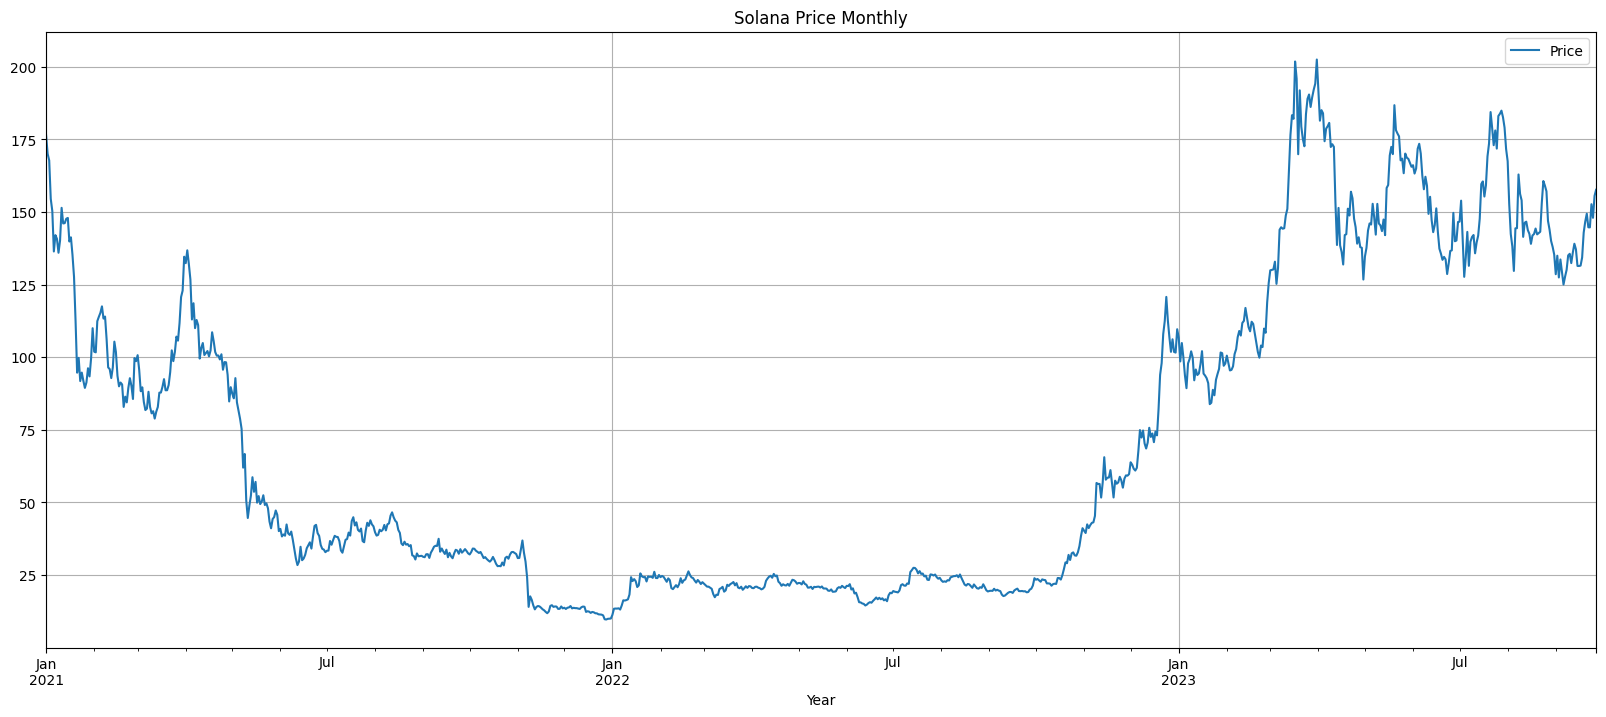

In [11]:
df.plot(figsize=(20,8))
plt.title("Solana Price Monthly")
plt.grid()

In [12]:
df.describe()

,Price
count,1000.000000
mean,70.157418
std,54.403528
min,9.658000
25%,22.623500
50%,41.031500
75%,112.655250
max,202.510000


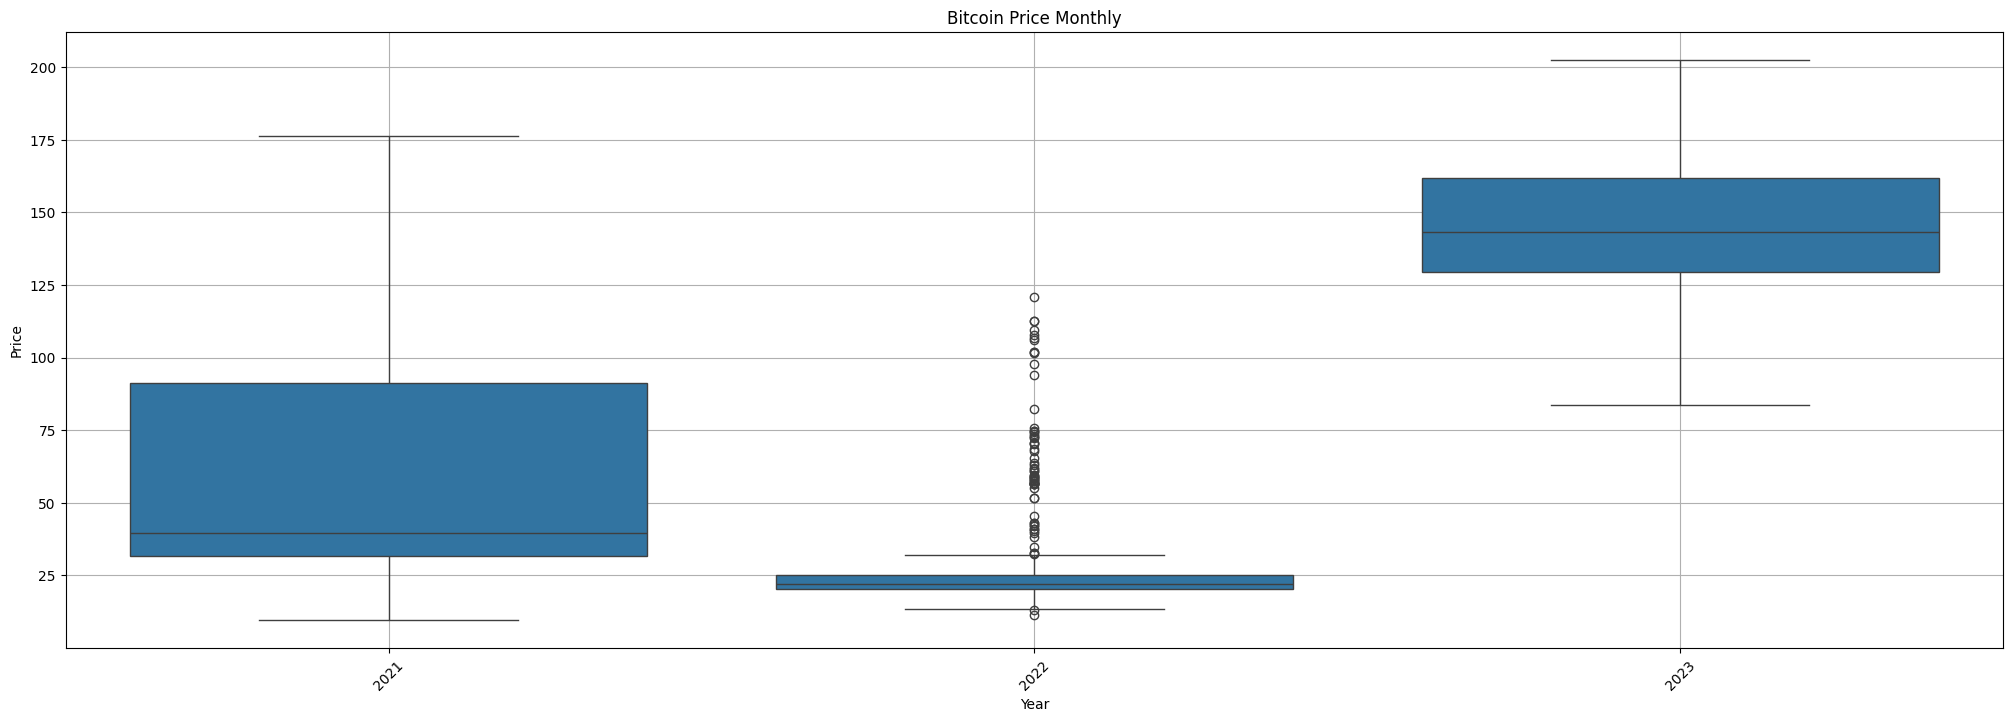

In [13]:
_ , ax = plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.year , y=df.values[:,0] , ax=ax)
plt.title("Bitcoin Price Monthly")
plt.xlabel(f"Year")
plt.ylabel(f"Price")
plt.xticks(rotation=45)
plt.grid()

Text(0.5, 1.0, 'Solana Price Monthly')

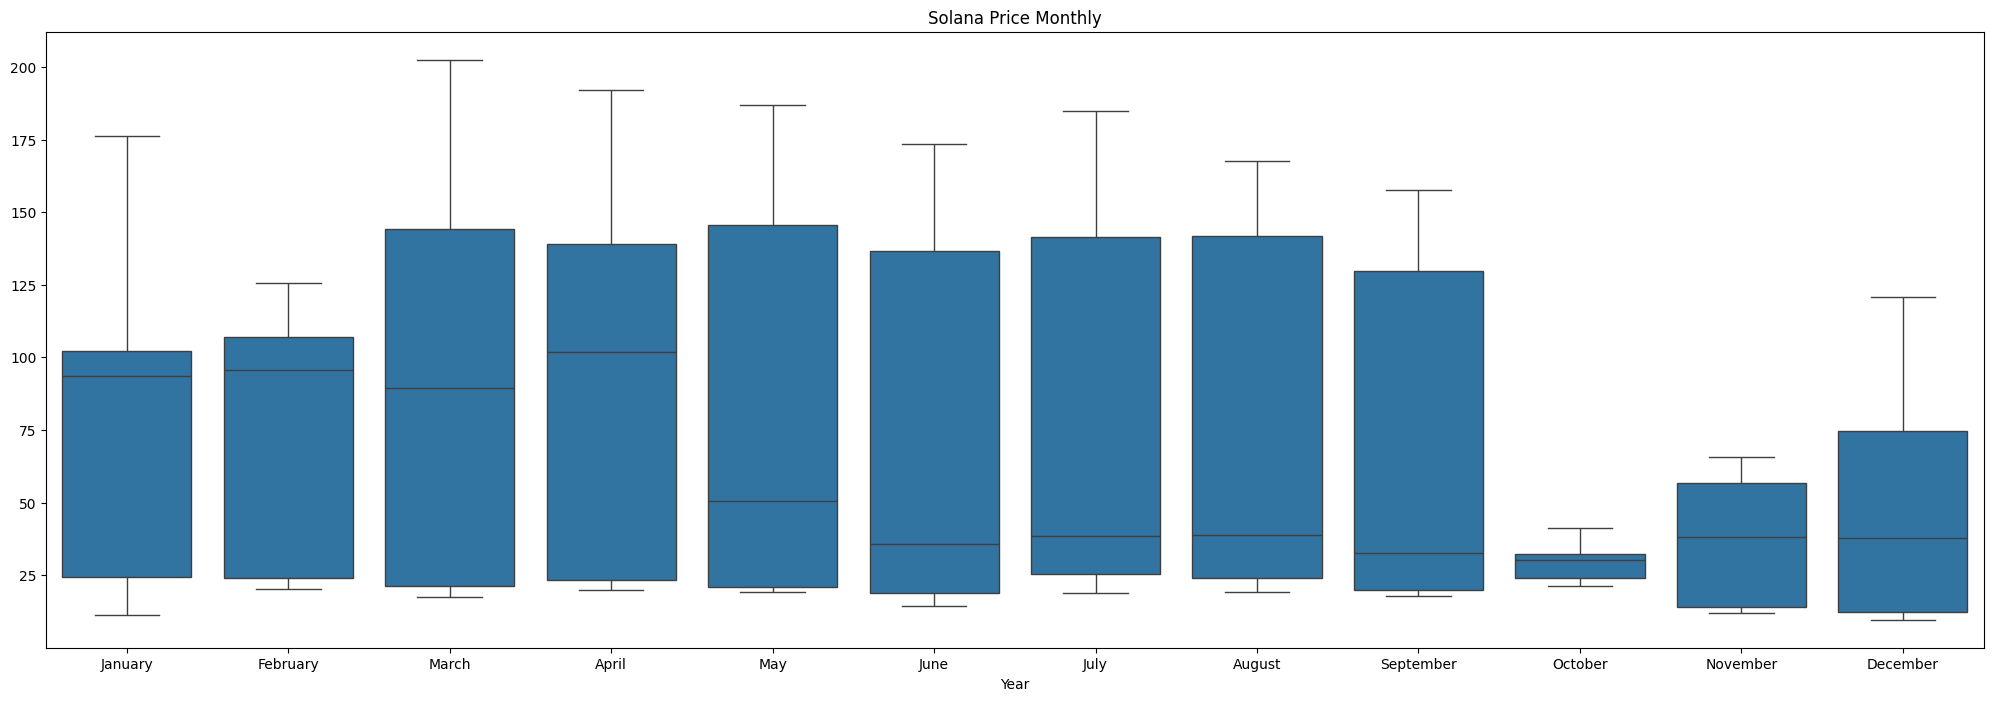

In [14]:
_ , ax = plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.month_name() , y = df.values[:,0], ax=ax)
plt.title("Solana Price Monthly")

In [15]:
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price' : 'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price' : 'Std'}), left_index=True, right_index=True)
df_1['Cov_pct'] = ((df_1['Std']/df_1['Mean'])*100 ).round(2)

In [16]:
df_1.head()

,Mean,Std,Cov_pct
Year,,,
2021,57.430145,38.710300,67.40
2022,29.577767,19.930207,67.38
2023,142.220481,27.568353,19.38


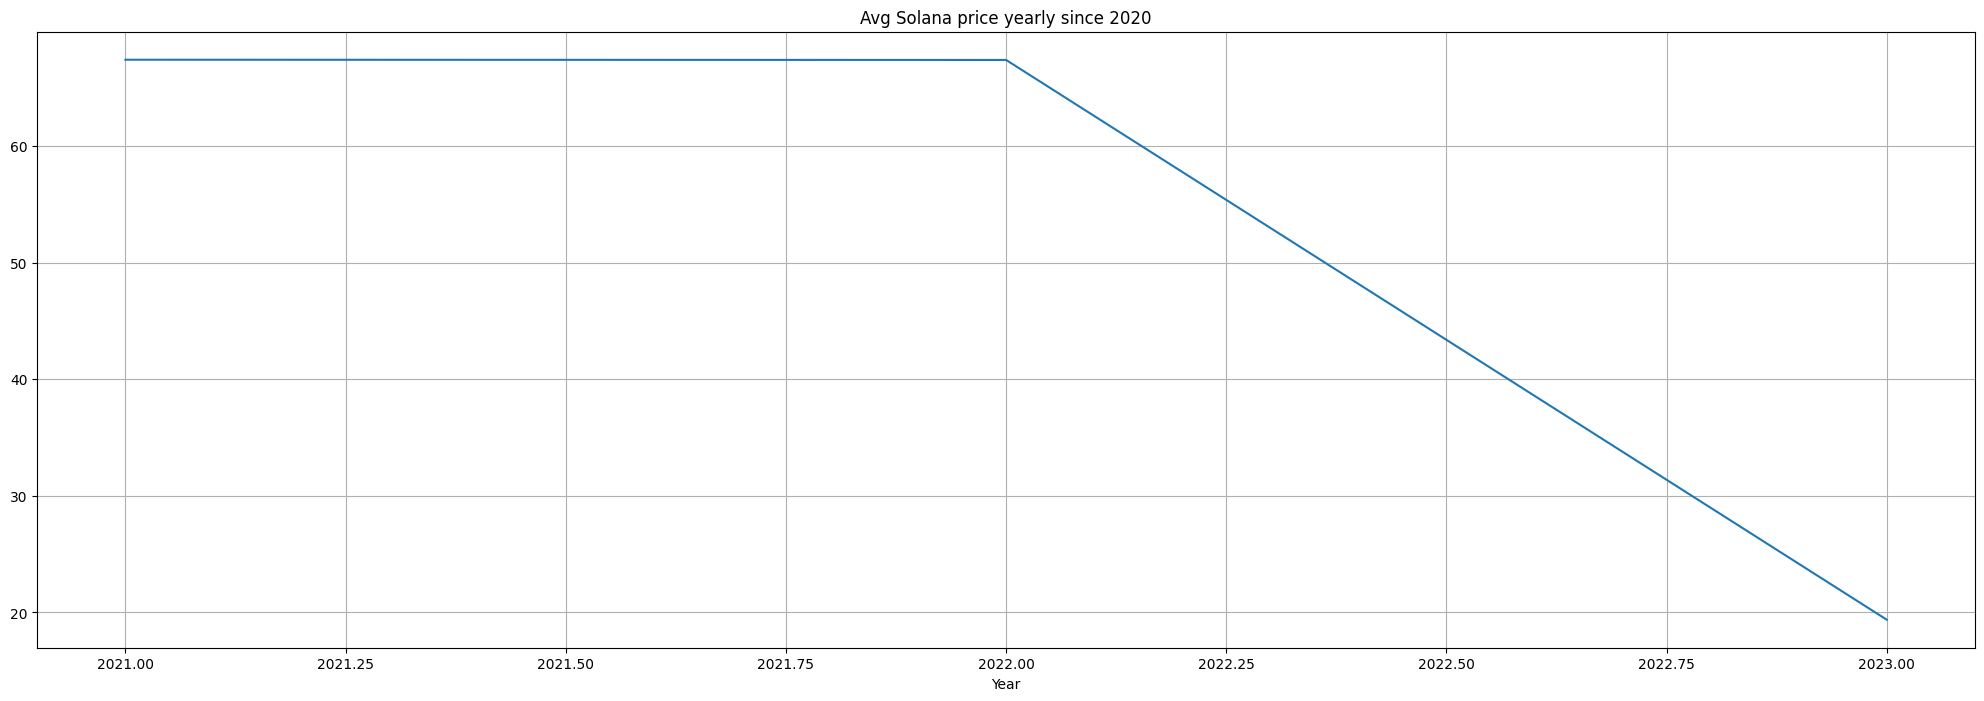

In [17]:
fig , ax = plt.subplots(figsize=(25,8))
df_1['Cov_pct'].plot()
plt.title("Avg Solana price yearly since 2020")
plt.grid()

In [18]:
train = df[df.index.year <= 2022]
test = df[df.index.year > 2022]

In [19]:
print(train.shape)
print(test.shape)

(730, 1)
(270, 1)


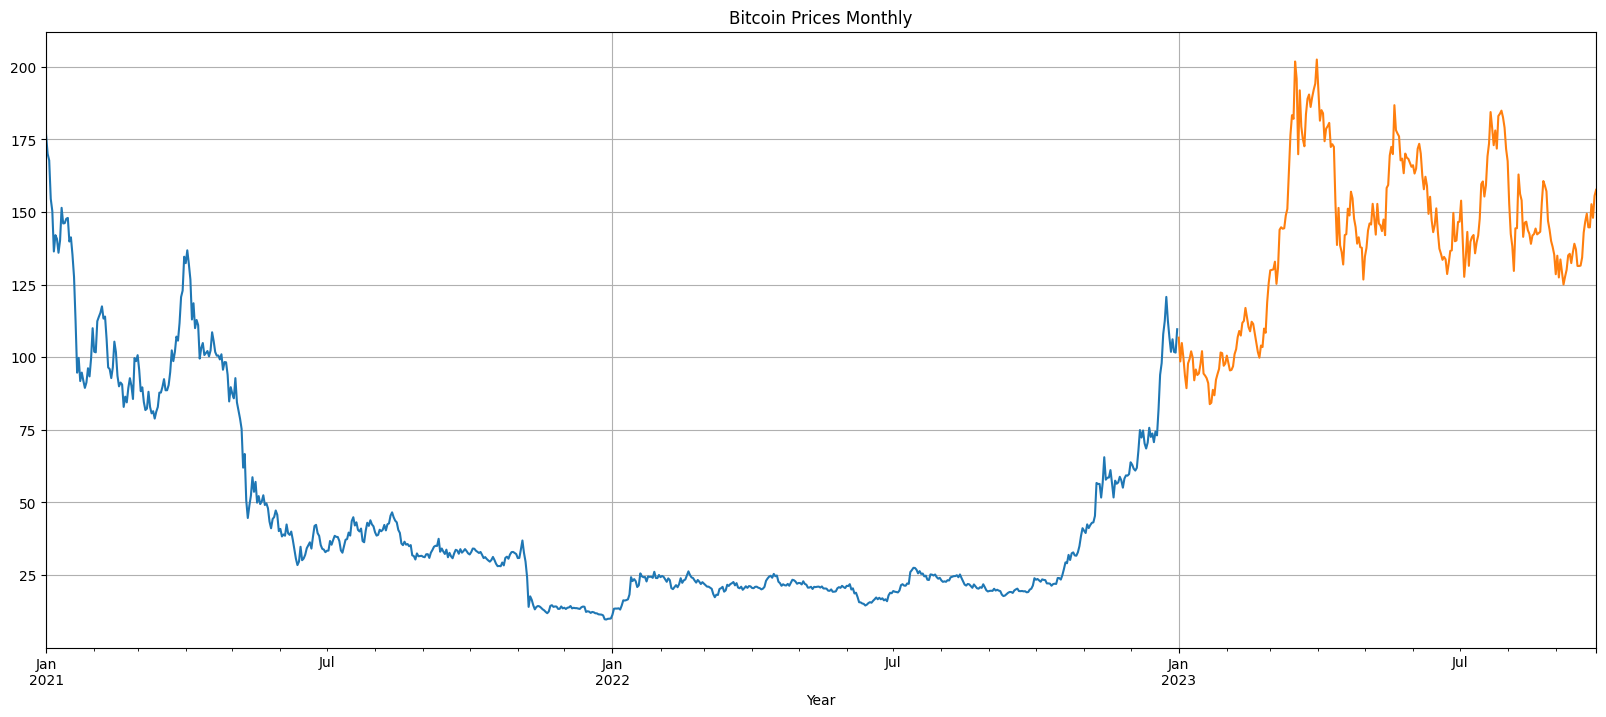

In [20]:
train['Price'].plot(figsize=(20,8))
test['Price'].plot(figsize=(20,8))
plt.title("Bitcoin Prices Monthly")
plt.grid()

In [21]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+1 for i in range(len(test))]
len(train_time), len(test_time)

(730, 270)

In [22]:
Naive_train = train.copy()
Naive_test = test.copy()

In [23]:
LR_train = train.copy()
LR_test = test.copy()

In [24]:
Naive_train['time'] = train_time
Naive_test['time'] = test_time

In [25]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [26]:
Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

,naive
Year,
2023-01-01,109.628
2023-01-02,109.628
2023-01-03,109.628
2023-01-04,109.628
2023-01-05,109.628


In [27]:
lr = LinearRegression()
lr.fit(LR_train[['time']], LR_train['Price'].values)

LinearRegression()

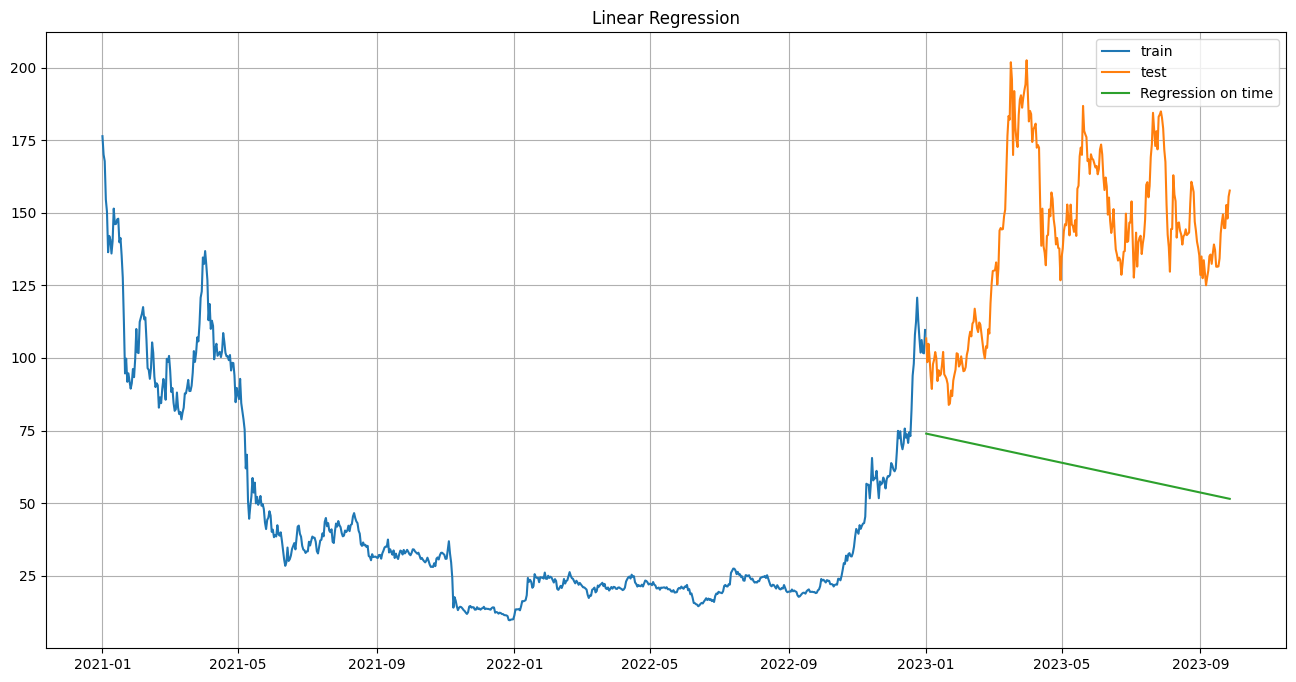

In [28]:
test_predictions_model = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model
plt.figure(figsize=(16,8))
plt.plot(train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(LR_test['forecast'], label='Regression on time')
plt.title('Linear Regression')
plt.legend(loc='best')
plt.grid()
plt.show()

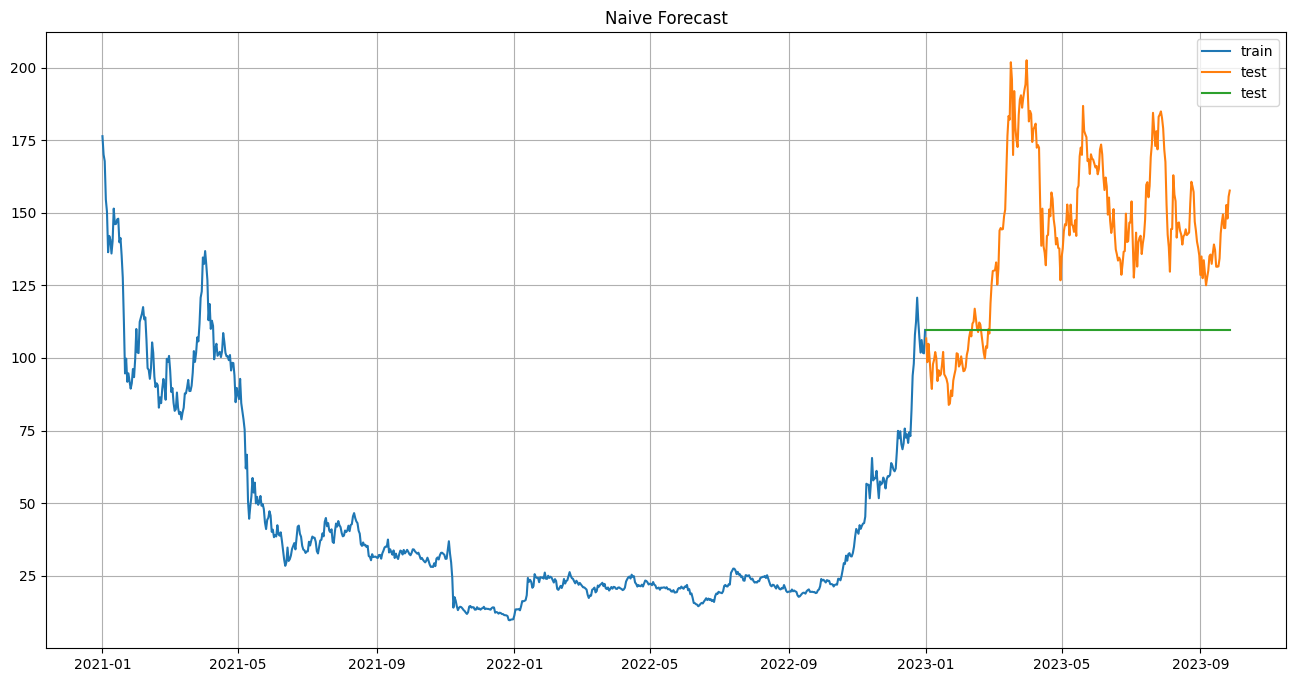

In [29]:
plt.figure(figsize=(16,8))
plt.plot(Naive_train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(Naive_test['naive'],label='test')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.grid()
plt.show()

In [30]:
def mape(actual,pred):
  return round((np.mean(abs(actual - pred)/actual))*100 , 2)

In [31]:
mape_model_test = mape(test['Price'].values,test_predictions_model)
print("MAPE is %3.3f"%(mape_model_test),"%")

MAPE is 53.460 %


In [32]:
results = pd.DataFrame({'Test MAPE (%)': [mape_model_test]}, index=["Regression"])

In [33]:
results

,Test MAPE (%)
Regression,53.46


In [34]:
mape_model_test_2 = mape(test['Price'].values,Naive_test['naive'].values)
print("For Naive Forecast on Test data the MAPE is %3.3f"%(mape_model_test_2),"%")

For Naive Forecast on Test data the MAPE is 23.970 %


In [35]:
results_2 = pd.DataFrame({'Test MAPE (%)': [mape_model_test_2]}, index=["Naive Model"])
result_final = pd.concat( [results,results_2])
result_final

,Test MAPE (%)
Regression,53.46
Naive Model,23.97


In [36]:
final_model = ExponentialSmoothing(df['Price'],trend='additive',seasonal='additive',seasonal_periods=12).fit(smoothing_level=0.4,smoothing_trend=0.3,smoothing_seasonal=0.6)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [37]:
# Ensure the forecasting period doesn't extend too far into the future
forecast_horizon = min(len(test), 30)  # Change 100 to a reasonable number if needed

# Perform the forecast
forecast = final_model.forecast(forecast_horizon)

# Compute the MAPE for the test period, ensuring it matches the forecast horizon
mape_final_model = mape(test['Price'].values[:forecast_horizon], forecast)
print("For Final Model on Test data the MAPE is %3.3f" % mape_final_model, "%")


For Final Model on Test data the MAPE is 55.300 %


In [38]:
# Limit the forecast horizon to prevent the out-of-bounds error
forecast_horizon = min(len(df), 20)  # Adjust 100 to a smaller number if needed

# Perform the forecast
prediction = final_model.forecast(forecast_horizon)


In [39]:
pred_df = pd.DataFrame({'lower_CI':prediction - 1.96*np.std(final_model.resid,ddof=1) , 'prediction':prediction , 'upper_CI':prediction + 1.96*np.std(final_model.resid,ddof=1)})

Text(0.5, 1.0, 'Final Model')

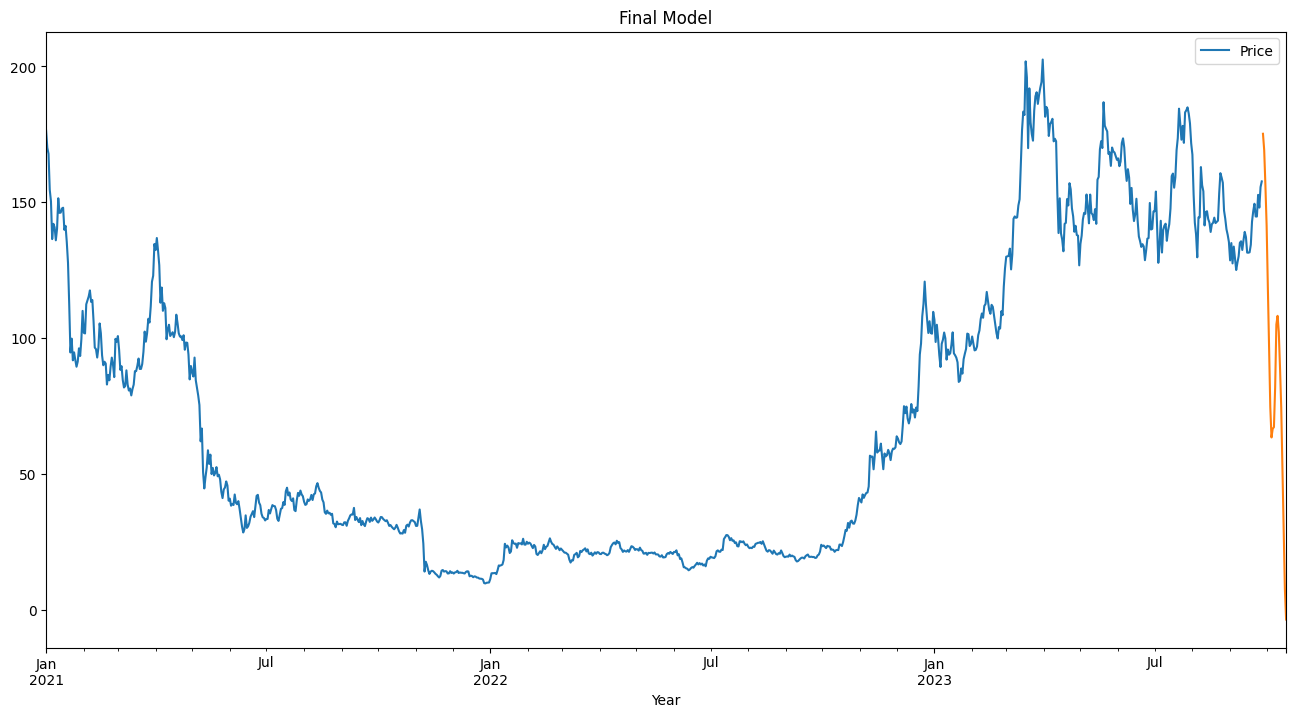

In [40]:
axis = df.plot(label = 'Actual',figsize=(16,8))
pred_df['prediction'].plot(ax=axis,label='Predicted')
plt.title('Final Model')

In [41]:
import pickle
from sklearn.linear_model import LinearRegression

# Save the model
with open('solana_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)
print("Model saved successfully as 'solana_model.pkl'.")

# Load the model
with open('solana_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")


Model saved successfully as 'solana_model.pkl'.
Model loaded successfully.
